In [142]:
from dream_model import DeepDreamModel
from torchvision.models import vgg16
import pathlib
from tqdm import tqdm
import torch
import torch.nn as nn
import numbers
import math

In [146]:
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """
    def __init__(self, kernel_size, sigma):
        super().__init__()

        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size, kernel_size]

        cascade_coefficients = [0.5, 1.0, 2.0]  # std multipliers
        sigmas = [[coeff * sigma, coeff * sigma] for coeff in cascade_coefficients]  # isotropic Gaussian

        self.pad = int(kernel_size[0] / 2)  # assure we have the same spatial resolution

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad, self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

In [169]:
import torch.nn.functional as F
from torchmetrics.functional import total_variation

def train_dream(dream_model, iterations=200):
    input_image = torch.rand(1, 3, 100, 100) #pyramid_image.img_torch
    input_image.requires_grad = True
    for iteration in tqdm(range(iterations)):
        out = dream_model(input_image)
        activations = dream_model.get_activations_by_types(["Linear"])[-1][0]
        losses = [torch.nn.MSELoss(reduction='mean')(activation, torch.zeros_like(activation)) for activation in activations]
        loss = torch.mean(torch.stack(losses))
#         regularization = -0.01*total_variation(input_image)
#         print(loss, regularization)
        loss = loss #+ regularization
        print(loss)
        loss.backward()
        grad = input_image.grad.data
        grad = CascadeGaussianSmoothing(kernel_size=9, sigma=3)(grad)
        grad_std = torch.std(grad)
        grad_mean = torch.mean(grad)
        grad -= grad_mean
        grad /= grad_std
        input_image.data += 0.01 * grad
        input_image.grad.data.zero_()
    return input_image
            
        

In [170]:
# image_path = pathlib.Path("examples/amazon.jpg")
# image = load_image(image_path)
dream_model = DeepDreamModel(vgg16(pretrained=True))

out = train_dream(dream_model)

  0%|                                                                        | 0/200 [00:00<?, ?it/s]

tensor(2.3671, grad_fn=<MeanBackward0>)


  0%|▎                                                               | 1/200 [00:00<02:02,  1.62it/s]

tensor(4.6042, grad_fn=<MeanBackward0>)


  1%|▋                                                               | 2/200 [00:01<01:54,  1.72it/s]

tensor(7.4278, grad_fn=<MeanBackward0>)


  2%|█▎                                                              | 4/200 [00:02<01:45,  1.85it/s]

tensor(10.9646, grad_fn=<MeanBackward0>)


  2%|█▌                                                              | 5/200 [00:02<01:43,  1.89it/s]

tensor(14.2780, grad_fn=<MeanBackward0>)
tensor(17.4748, grad_fn=<MeanBackward0>)


  3%|█▉                                                              | 6/200 [00:03<01:43,  1.88it/s]

tensor(20.0711, grad_fn=<MeanBackward0>)


  4%|██▏                                                             | 7/200 [00:03<01:42,  1.87it/s]

tensor(23.4953, grad_fn=<MeanBackward0>)


  4%|██▌                                                             | 8/200 [00:04<01:44,  1.84it/s]

tensor(27.4350, grad_fn=<MeanBackward0>)


  4%|██▉                                                             | 9/200 [00:04<01:45,  1.81it/s]

tensor(30.6194, grad_fn=<MeanBackward0>)


  5%|███▏                                                           | 10/200 [00:05<01:49,  1.74it/s]

tensor(34.8535, grad_fn=<MeanBackward0>)


  6%|███▍                                                           | 11/200 [00:06<01:48,  1.74it/s]

tensor(39.0866, grad_fn=<MeanBackward0>)


  6%|███▊                                                           | 12/200 [00:06<01:51,  1.68it/s]

tensor(44.3247, grad_fn=<MeanBackward0>)


  7%|████▍                                                          | 14/200 [00:07<01:42,  1.81it/s]

tensor(50.7334, grad_fn=<MeanBackward0>)
tensor(56.7987, grad_fn=<MeanBackward0>)


  8%|█████                                                          | 16/200 [00:08<01:34,  1.94it/s]

tensor(63.1323, grad_fn=<MeanBackward0>)
tensor(67.9201, grad_fn=<MeanBackward0>)


  8%|█████▎                                                         | 17/200 [00:09<01:40,  1.82it/s]

tensor(72.0382, grad_fn=<MeanBackward0>)


  9%|█████▋                                                         | 18/200 [00:10<01:46,  1.71it/s]

tensor(78.6515, grad_fn=<MeanBackward0>)


 10%|█████▉                                                         | 19/200 [00:10<01:48,  1.67it/s]

tensor(84.3369, grad_fn=<MeanBackward0>)


 10%|██████▎                                                        | 20/200 [00:11<01:50,  1.63it/s]

tensor(90.3115, grad_fn=<MeanBackward0>)


 10%|██████▌                                                        | 21/200 [00:12<01:57,  1.52it/s]

tensor(97.3382, grad_fn=<MeanBackward0>)


 11%|██████▉                                                        | 22/200 [00:12<02:06,  1.40it/s]

tensor(104.6621, grad_fn=<MeanBackward0>)


 12%|███████▏                                                       | 23/200 [00:13<02:12,  1.34it/s]

tensor(113.1853, grad_fn=<MeanBackward0>)


 12%|███████▌                                                       | 24/200 [00:14<02:12,  1.33it/s]

tensor(120.6991, grad_fn=<MeanBackward0>)


 12%|███████▉                                                       | 25/200 [00:15<02:15,  1.30it/s]

tensor(129.2189, grad_fn=<MeanBackward0>)


 13%|████████▏                                                      | 26/200 [00:16<02:22,  1.22it/s]

tensor(136.2498, grad_fn=<MeanBackward0>)


 14%|████████▌                                                      | 27/200 [00:16<02:11,  1.31it/s]

tensor(144.6031, grad_fn=<MeanBackward0>)


 14%|████████▊                                                      | 28/200 [00:17<02:02,  1.40it/s]

tensor(149.1114, grad_fn=<MeanBackward0>)


 14%|█████████▏                                                     | 29/200 [00:18<01:59,  1.43it/s]

tensor(159.8982, grad_fn=<MeanBackward0>)


 15%|█████████▍                                                     | 30/200 [00:18<01:57,  1.44it/s]

tensor(160.3288, grad_fn=<MeanBackward0>)


 16%|█████████▊                                                     | 31/200 [00:19<01:48,  1.56it/s]

tensor(171.9719, grad_fn=<MeanBackward0>)


 16%|██████████                                                     | 32/200 [00:19<01:43,  1.62it/s]

tensor(176.5291, grad_fn=<MeanBackward0>)


 16%|██████████▍                                                    | 33/200 [00:20<01:41,  1.64it/s]

tensor(185.9843, grad_fn=<MeanBackward0>)


 17%|██████████▋                                                    | 34/200 [00:21<01:42,  1.62it/s]

tensor(191.7125, grad_fn=<MeanBackward0>)


 18%|███████████                                                    | 35/200 [00:21<01:45,  1.57it/s]

tensor(197.2039, grad_fn=<MeanBackward0>)


 18%|███████████▎                                                   | 36/200 [00:22<01:47,  1.53it/s]

tensor(206.8552, grad_fn=<MeanBackward0>)


 18%|███████████▋                                                   | 37/200 [00:23<01:41,  1.60it/s]

tensor(210.8734, grad_fn=<MeanBackward0>)


 19%|███████████▉                                                   | 38/200 [00:23<01:38,  1.65it/s]

tensor(223.2952, grad_fn=<MeanBackward0>)


 20%|████████████▎                                                  | 39/200 [00:24<01:34,  1.71it/s]

tensor(228.9784, grad_fn=<MeanBackward0>)


 20%|████████████▌                                                  | 40/200 [00:24<01:32,  1.73it/s]

tensor(242.8675, grad_fn=<MeanBackward0>)


 20%|████████████▉                                                  | 41/200 [00:25<01:35,  1.67it/s]

tensor(246.4470, grad_fn=<MeanBackward0>)


 21%|█████████████▏                                                 | 42/200 [00:26<01:35,  1.65it/s]

tensor(260.3951, grad_fn=<MeanBackward0>)


 22%|█████████████▌                                                 | 43/200 [00:26<01:35,  1.65it/s]

tensor(261.9237, grad_fn=<MeanBackward0>)


 22%|█████████████▊                                                 | 44/200 [00:27<01:31,  1.70it/s]

tensor(278.3821, grad_fn=<MeanBackward0>)


 22%|██████████████▏                                                | 45/200 [00:27<01:33,  1.66it/s]

tensor(281.7064, grad_fn=<MeanBackward0>)


 23%|██████████████▍                                                | 46/200 [00:28<01:29,  1.73it/s]

tensor(296.2371, grad_fn=<MeanBackward0>)


 24%|██████████████▊                                                | 47/200 [00:28<01:27,  1.76it/s]

tensor(299.8394, grad_fn=<MeanBackward0>)


 24%|███████████████                                                | 48/200 [00:29<01:30,  1.69it/s]

tensor(314.5568, grad_fn=<MeanBackward0>)


 24%|███████████████▍                                               | 49/200 [00:30<01:30,  1.67it/s]

tensor(318.5500, grad_fn=<MeanBackward0>)


 25%|███████████████▊                                               | 50/200 [00:30<01:29,  1.68it/s]

tensor(332.8967, grad_fn=<MeanBackward0>)


 26%|████████████████                                               | 51/200 [00:31<01:35,  1.56it/s]

tensor(334.8609, grad_fn=<MeanBackward0>)


 26%|████████████████▍                                              | 52/200 [00:32<01:37,  1.52it/s]

tensor(352.1116, grad_fn=<MeanBackward0>)


 26%|████████████████▋                                              | 53/200 [00:32<01:39,  1.48it/s]

tensor(355.8304, grad_fn=<MeanBackward0>)


 27%|█████████████████                                              | 54/200 [00:33<01:37,  1.49it/s]

tensor(368.2653, grad_fn=<MeanBackward0>)


 28%|█████████████████▎                                             | 55/200 [00:34<01:33,  1.55it/s]

tensor(373.8843, grad_fn=<MeanBackward0>)


 28%|█████████████████▋                                             | 56/200 [00:34<01:28,  1.63it/s]

tensor(386.7504, grad_fn=<MeanBackward0>)


 28%|█████████████████▉                                             | 57/200 [00:35<01:29,  1.60it/s]

tensor(390.4891, grad_fn=<MeanBackward0>)


 30%|██████████████████▌                                            | 59/200 [00:36<01:21,  1.74it/s]

tensor(404.6623, grad_fn=<MeanBackward0>)


 30%|██████████████████▉                                            | 60/200 [00:36<01:19,  1.77it/s]

tensor(409.7758, grad_fn=<MeanBackward0>)


 30%|███████████████████▏                                           | 61/200 [00:37<01:21,  1.71it/s]

tensor(424.8334, grad_fn=<MeanBackward0>)
tensor(435.8688, grad_fn=<MeanBackward0>)


 31%|███████████████████▌                                           | 62/200 [00:38<01:20,  1.71it/s]

tensor(447.5714, grad_fn=<MeanBackward0>)


 32%|███████████████████▊                                           | 63/200 [00:38<01:21,  1.68it/s]

tensor(458.2990, grad_fn=<MeanBackward0>)


 32%|████████████████████▏                                          | 64/200 [00:39<01:22,  1.64it/s]

tensor(472.1879, grad_fn=<MeanBackward0>)


 32%|████████████████████▍                                          | 65/200 [00:40<01:23,  1.61it/s]

tensor(481.1133, grad_fn=<MeanBackward0>)


 33%|████████████████████▊                                          | 66/200 [00:40<01:23,  1.60it/s]

tensor(491.5914, grad_fn=<MeanBackward0>)


 34%|█████████████████████                                          | 67/200 [00:41<01:21,  1.63it/s]

tensor(500.9101, grad_fn=<MeanBackward0>)


 34%|█████████████████████▍                                         | 68/200 [00:41<01:20,  1.64it/s]

tensor(513.9650, grad_fn=<MeanBackward0>)


 34%|█████████████████████▋                                         | 69/200 [00:42<01:17,  1.69it/s]

tensor(523.6154, grad_fn=<MeanBackward0>)


 35%|██████████████████████                                         | 70/200 [00:43<01:16,  1.70it/s]

tensor(536.9218, grad_fn=<MeanBackward0>)


 36%|██████████████████████▎                                        | 71/200 [00:43<01:13,  1.76it/s]

tensor(546.5836, grad_fn=<MeanBackward0>)


 36%|██████████████████████▋                                        | 72/200 [00:44<01:16,  1.67it/s]

tensor(560.3322, grad_fn=<MeanBackward0>)


 37%|███████████████████████▎                                       | 74/200 [00:45<01:10,  1.78it/s]

tensor(573.9888, grad_fn=<MeanBackward0>)
tensor(583.8583, grad_fn=<MeanBackward0>)


 38%|███████████████████████▋                                       | 75/200 [00:45<01:09,  1.80it/s]

tensor(599.1860, grad_fn=<MeanBackward0>)


 38%|███████████████████████▉                                       | 76/200 [00:46<01:07,  1.84it/s]

tensor(611.1408, grad_fn=<MeanBackward0>)


 38%|████████████████████████▎                                      | 77/200 [00:46<01:07,  1.81it/s]

tensor(625.8078, grad_fn=<MeanBackward0>)


 39%|████████████████████████▌                                      | 78/200 [00:47<01:06,  1.84it/s]

tensor(637.1692, grad_fn=<MeanBackward0>)


 40%|████████████████████████▉                                      | 79/200 [00:48<01:08,  1.76it/s]

tensor(653.6818, grad_fn=<MeanBackward0>)


 40%|█████████████████████████▏                                     | 80/200 [00:48<01:06,  1.80it/s]

tensor(663.3140, grad_fn=<MeanBackward0>)


 40%|█████████████████████████▌                                     | 81/200 [00:49<01:04,  1.84it/s]

tensor(677.4980, grad_fn=<MeanBackward0>)


 41%|█████████████████████████▊                                     | 82/200 [00:49<01:03,  1.85it/s]

tensor(687.6473, grad_fn=<MeanBackward0>)


 42%|██████████████████████████▏                                    | 83/200 [00:50<01:00,  1.93it/s]

tensor(705.2311, grad_fn=<MeanBackward0>)


 42%|██████████████████████████▊                                    | 85/200 [00:51<00:58,  1.96it/s]

tensor(716.5840, grad_fn=<MeanBackward0>)
tensor(735.0980, grad_fn=<MeanBackward0>)


 43%|███████████████████████████                                    | 86/200 [00:51<01:00,  1.89it/s]

tensor(742.9925, grad_fn=<MeanBackward0>)


 44%|███████████████████████████▍                                   | 87/200 [00:52<01:01,  1.84it/s]

tensor(761.3534, grad_fn=<MeanBackward0>)


 44%|███████████████████████████▋                                   | 88/200 [00:52<01:05,  1.72it/s]

tensor(771.2179, grad_fn=<MeanBackward0>)


 44%|████████████████████████████                                   | 89/200 [00:53<01:07,  1.64it/s]

tensor(787.7797, grad_fn=<MeanBackward0>)


 45%|████████████████████████████▎                                  | 90/200 [00:54<01:09,  1.59it/s]

tensor(799.9473, grad_fn=<MeanBackward0>)


 46%|████████████████████████████▋                                  | 91/200 [00:55<01:14,  1.46it/s]

tensor(817.6070, grad_fn=<MeanBackward0>)


 46%|████████████████████████████▉                                  | 92/200 [00:56<01:32,  1.17it/s]

tensor(831.9495, grad_fn=<MeanBackward0>)


 46%|█████████████████████████████▎                                 | 93/200 [00:57<01:50,  1.04s/it]

tensor(847.4610, grad_fn=<MeanBackward0>)


 47%|█████████████████████████████▌                                 | 94/200 [00:59<02:00,  1.13s/it]

tensor(861.5244, grad_fn=<MeanBackward0>)


 48%|█████████████████████████████▉                                 | 95/200 [01:00<01:53,  1.08s/it]

tensor(876.4380, grad_fn=<MeanBackward0>)


 48%|██████████████████████████████▏                                | 96/200 [01:01<01:49,  1.05s/it]

tensor(894.5674, grad_fn=<MeanBackward0>)


 48%|██████████████████████████████▌                                | 97/200 [01:01<01:39,  1.03it/s]

tensor(913.3700, grad_fn=<MeanBackward0>)


 49%|██████████████████████████████▊                                | 98/200 [01:02<01:43,  1.01s/it]

tensor(932.5002, grad_fn=<MeanBackward0>)


 50%|███████████████████████████████▏                               | 99/200 [01:04<02:02,  1.22s/it]

tensor(948.0787, grad_fn=<MeanBackward0>)


 50%|███████████████████████████████                               | 100/200 [01:05<01:45,  1.06s/it]

tensor(969.0521, grad_fn=<MeanBackward0>)


 50%|███████████████████████████████▎                              | 101/200 [01:06<01:33,  1.06it/s]

tensor(984.1321, grad_fn=<MeanBackward0>)


 51%|███████████████████████████████▌                              | 102/200 [01:06<01:24,  1.15it/s]

tensor(1004.3244, grad_fn=<MeanBackward0>)


 52%|███████████████████████████████▉                              | 103/200 [01:07<01:17,  1.25it/s]

tensor(1017.9146, grad_fn=<MeanBackward0>)


 52%|████████████████████████████████▏                             | 104/200 [01:08<01:12,  1.32it/s]

tensor(1037.3220, grad_fn=<MeanBackward0>)


 52%|████████████████████████████████▌                             | 105/200 [01:09<01:37,  1.03s/it]

tensor(1050.1404, grad_fn=<MeanBackward0>)


 53%|████████████████████████████████▊                             | 106/200 [01:10<01:27,  1.07it/s]

tensor(1069.4038, grad_fn=<MeanBackward0>)


 54%|█████████████████████████████████▏                            | 107/200 [01:11<01:20,  1.15it/s]

tensor(1081.1652, grad_fn=<MeanBackward0>)


 54%|█████████████████████████████████▍                            | 108/200 [01:11<01:17,  1.19it/s]

tensor(1102.7247, grad_fn=<MeanBackward0>)


 55%|█████████████████████████████████▊                            | 109/200 [01:12<01:14,  1.22it/s]

tensor(1110.5032, grad_fn=<MeanBackward0>)


 55%|██████████████████████████████████                            | 110/200 [01:13<01:09,  1.29it/s]

tensor(1131.5442, grad_fn=<MeanBackward0>)


 56%|██████████████████████████████████▍                           | 111/200 [01:13<01:05,  1.35it/s]

tensor(1143.0106, grad_fn=<MeanBackward0>)


 56%|██████████████████████████████████▋                           | 112/200 [01:14<01:01,  1.43it/s]

tensor(1161.3700, grad_fn=<MeanBackward0>)


 56%|███████████████████████████████████                           | 113/200 [01:15<01:00,  1.43it/s]

tensor(1175.5835, grad_fn=<MeanBackward0>)


 57%|███████████████████████████████████▎                          | 114/200 [01:15<00:59,  1.46it/s]

tensor(1190.1503, grad_fn=<MeanBackward0>)


 57%|███████████████████████████████████▋                          | 115/200 [01:16<01:02,  1.37it/s]

tensor(1207.4991, grad_fn=<MeanBackward0>)


 58%|███████████████████████████████████▉                          | 116/200 [01:17<01:00,  1.39it/s]

tensor(1223.8726, grad_fn=<MeanBackward0>)


 58%|████████████████████████████████████▎                         | 117/200 [01:18<00:57,  1.44it/s]

tensor(1239.6200, grad_fn=<MeanBackward0>)


 59%|████████████████████████████████████▌                         | 118/200 [01:18<00:55,  1.49it/s]

tensor(1257.4187, grad_fn=<MeanBackward0>)


 60%|████████████████████████████████████▉                         | 119/200 [01:19<00:53,  1.52it/s]

tensor(1270.6654, grad_fn=<MeanBackward0>)


 60%|█████████████████████████████████████▏                        | 120/200 [01:19<00:52,  1.52it/s]

tensor(1285.1531, grad_fn=<MeanBackward0>)


 60%|█████████████████████████████████████▌                        | 121/200 [01:20<00:50,  1.56it/s]

tensor(1299.6179, grad_fn=<MeanBackward0>)


 61%|█████████████████████████████████████▊                        | 122/200 [01:21<00:50,  1.56it/s]

tensor(1312.1244, grad_fn=<MeanBackward0>)


 62%|██████████████████████████████████████▏                       | 123/200 [01:21<00:48,  1.60it/s]

tensor(1332.3816, grad_fn=<MeanBackward0>)


 62%|██████████████████████████████████████▍                       | 124/200 [01:22<00:46,  1.65it/s]

tensor(1340.2772, grad_fn=<MeanBackward0>)


 62%|██████████████████████████████████████▊                       | 125/200 [01:23<00:45,  1.65it/s]

tensor(1355.7241, grad_fn=<MeanBackward0>)


 63%|███████████████████████████████████████                       | 126/200 [01:23<00:45,  1.64it/s]

tensor(1367.9274, grad_fn=<MeanBackward0>)


 64%|███████████████████████████████████████▎                      | 127/200 [01:24<00:45,  1.61it/s]

tensor(1384.9058, grad_fn=<MeanBackward0>)


 64%|███████████████████████████████████████▋                      | 128/200 [01:24<00:43,  1.65it/s]

tensor(1396.9514, grad_fn=<MeanBackward0>)


 64%|███████████████████████████████████████▉                      | 129/200 [01:25<00:43,  1.64it/s]

tensor(1414.1591, grad_fn=<MeanBackward0>)


 65%|████████████████████████████████████████▎                     | 130/200 [01:26<00:42,  1.64it/s]

tensor(1428.7214, grad_fn=<MeanBackward0>)


 66%|████████████████████████████████████████▌                     | 131/200 [01:26<00:42,  1.64it/s]

tensor(1443.1189, grad_fn=<MeanBackward0>)


 66%|█████████████████████████████████████████▏                    | 133/200 [01:27<00:40,  1.65it/s]

tensor(1455.9832, grad_fn=<MeanBackward0>)
tensor(1470.0750, grad_fn=<MeanBackward0>)


 67%|█████████████████████████████████████████▌                    | 134/200 [01:28<00:40,  1.62it/s]

tensor(1485.4756, grad_fn=<MeanBackward0>)


 68%|█████████████████████████████████████████▊                    | 135/200 [01:29<00:39,  1.66it/s]

tensor(1499.0742, grad_fn=<MeanBackward0>)


 68%|██████████████████████████████████████████▏                   | 136/200 [01:29<00:37,  1.73it/s]

tensor(1511.4543, grad_fn=<MeanBackward0>)


 68%|██████████████████████████████████████████▍                   | 137/200 [01:30<00:35,  1.79it/s]

tensor(1523.2297, grad_fn=<MeanBackward0>)


 69%|██████████████████████████████████████████▊                   | 138/200 [01:30<00:34,  1.79it/s]

tensor(1538.2200, grad_fn=<MeanBackward0>)


 70%|███████████████████████████████████████████                   | 139/200 [01:31<00:33,  1.80it/s]

tensor(1550.4888, grad_fn=<MeanBackward0>)


 70%|███████████████████████████████████████████▍                  | 140/200 [01:31<00:33,  1.80it/s]

tensor(1565.8396, grad_fn=<MeanBackward0>)


 70%|███████████████████████████████████████████▋                  | 141/200 [01:32<00:33,  1.74it/s]

tensor(1576.7080, grad_fn=<MeanBackward0>)


 71%|████████████████████████████████████████████                  | 142/200 [01:33<00:34,  1.67it/s]

tensor(1590.8990, grad_fn=<MeanBackward0>)


 72%|████████████████████████████████████████████▎                 | 143/200 [01:33<00:34,  1.65it/s]

tensor(1603.2404, grad_fn=<MeanBackward0>)


 72%|████████████████████████████████████████████▋                 | 144/200 [01:34<00:34,  1.62it/s]

tensor(1614.4823, grad_fn=<MeanBackward0>)


 72%|████████████████████████████████████████████▉                 | 145/200 [01:34<00:32,  1.67it/s]

tensor(1623.6710, grad_fn=<MeanBackward0>)


 73%|█████████████████████████████████████████████▎                | 146/200 [01:35<00:31,  1.70it/s]

tensor(1637.9725, grad_fn=<MeanBackward0>)


 74%|█████████████████████████████████████████████▌                | 147/200 [01:36<00:30,  1.73it/s]

tensor(1647.0417, grad_fn=<MeanBackward0>)


 74%|█████████████████████████████████████████████▉                | 148/200 [01:36<00:29,  1.79it/s]

tensor(1659.1697, grad_fn=<MeanBackward0>)


 74%|██████████████████████████████████████████████▏               | 149/200 [01:37<00:28,  1.81it/s]

tensor(1666.3790, grad_fn=<MeanBackward0>)


 75%|██████████████████████████████████████████████▌               | 150/200 [01:37<00:28,  1.75it/s]

tensor(1682.2976, grad_fn=<MeanBackward0>)


 76%|██████████████████████████████████████████████▊               | 151/200 [01:38<00:28,  1.72it/s]

tensor(1689.5934, grad_fn=<MeanBackward0>)


 76%|███████████████████████████████████████████████               | 152/200 [01:38<00:29,  1.62it/s]

tensor(1708.1069, grad_fn=<MeanBackward0>)


 76%|███████████████████████████████████████████████▍              | 153/200 [01:39<00:30,  1.56it/s]

tensor(1715.7174, grad_fn=<MeanBackward0>)


 77%|███████████████████████████████████████████████▋              | 154/200 [01:40<00:30,  1.52it/s]

tensor(1735.2020, grad_fn=<MeanBackward0>)


 78%|████████████████████████████████████████████████              | 155/200 [01:41<00:32,  1.39it/s]

tensor(1741.6445, grad_fn=<MeanBackward0>)


 78%|████████████████████████████████████████████████▎             | 156/200 [01:42<00:39,  1.11it/s]

tensor(1760.9741, grad_fn=<MeanBackward0>)


 78%|████████████████████████████████████████████████▋             | 157/200 [01:43<00:36,  1.18it/s]

tensor(1768.9082, grad_fn=<MeanBackward0>)


 79%|████████████████████████████████████████████████▉             | 158/200 [01:44<00:40,  1.05it/s]

tensor(1785.6370, grad_fn=<MeanBackward0>)


 80%|█████████████████████████████████████████████████▎            | 159/200 [01:45<00:38,  1.08it/s]

tensor(1794.7942, grad_fn=<MeanBackward0>)


 80%|█████████████████████████████████████████████████▌            | 160/200 [01:46<00:35,  1.14it/s]

tensor(1807.2618, grad_fn=<MeanBackward0>)


 80%|█████████████████████████████████████████████████▉            | 161/200 [01:47<00:35,  1.10it/s]

tensor(1820.0868, grad_fn=<MeanBackward0>)


 81%|██████████████████████████████████████████████████▏           | 162/200 [01:48<00:35,  1.08it/s]

tensor(1828.9398, grad_fn=<MeanBackward0>)


 82%|██████████████████████████████████████████████████▌           | 163/200 [01:48<00:32,  1.16it/s]

tensor(1843.5846, grad_fn=<MeanBackward0>)


 82%|██████████████████████████████████████████████████▊           | 164/200 [01:49<00:28,  1.25it/s]

tensor(1852.7843, grad_fn=<MeanBackward0>)


 82%|███████████████████████████████████████████████████▏          | 165/200 [01:50<00:26,  1.34it/s]

tensor(1868.7793, grad_fn=<MeanBackward0>)


 83%|███████████████████████████████████████████████████▍          | 166/200 [01:50<00:26,  1.29it/s]

tensor(1881.2621, grad_fn=<MeanBackward0>)


 84%|███████████████████████████████████████████████████▊          | 167/200 [01:51<00:24,  1.32it/s]

tensor(1892.3247, grad_fn=<MeanBackward0>)


 84%|████████████████████████████████████████████████████          | 168/200 [01:52<00:23,  1.36it/s]

tensor(1909.4572, grad_fn=<MeanBackward0>)


 84%|████████████████████████████████████████████████████▍         | 169/200 [01:52<00:22,  1.38it/s]

tensor(1915.4768, grad_fn=<MeanBackward0>)


 85%|████████████████████████████████████████████████████▋         | 170/200 [01:53<00:20,  1.44it/s]

tensor(1935.7739, grad_fn=<MeanBackward0>)


 86%|█████████████████████████████████████████████████████         | 171/200 [01:54<00:20,  1.44it/s]

tensor(1940.9658, grad_fn=<MeanBackward0>)


 86%|█████████████████████████████████████████████████████▎        | 172/200 [01:55<00:21,  1.33it/s]

tensor(1962.8816, grad_fn=<MeanBackward0>)


 86%|█████████████████████████████████████████████████████▋        | 173/200 [01:55<00:20,  1.31it/s]

tensor(1968.2565, grad_fn=<MeanBackward0>)


 87%|█████████████████████████████████████████████████████▉        | 174/200 [01:56<00:19,  1.34it/s]

tensor(1987.3339, grad_fn=<MeanBackward0>)


 88%|██████████████████████████████████████████████████████▎       | 175/200 [01:57<00:17,  1.39it/s]

tensor(1993.4062, grad_fn=<MeanBackward0>)


 88%|██████████████████████████████████████████████████████▌       | 176/200 [01:57<00:16,  1.43it/s]

tensor(2011.1295, grad_fn=<MeanBackward0>)


 88%|██████████████████████████████████████████████████████▊       | 177/200 [01:58<00:15,  1.46it/s]

tensor(2015.0942, grad_fn=<MeanBackward0>)


 89%|███████████████████████████████████████████████████████▏      | 178/200 [01:59<00:16,  1.32it/s]

tensor(2034.0966, grad_fn=<MeanBackward0>)


 90%|███████████████████████████████████████████████████████▍      | 179/200 [02:00<00:15,  1.35it/s]

tensor(2040.6589, grad_fn=<MeanBackward0>)


 90%|███████████████████████████████████████████████████████▊      | 180/200 [02:00<00:14,  1.37it/s]

tensor(2056.4314, grad_fn=<MeanBackward0>)


 90%|████████████████████████████████████████████████████████      | 181/200 [02:01<00:13,  1.42it/s]

tensor(2061.6938, grad_fn=<MeanBackward0>)


 91%|████████████████████████████████████████████████████████▍     | 182/200 [02:02<00:12,  1.39it/s]

tensor(2078.9106, grad_fn=<MeanBackward0>)


 92%|████████████████████████████████████████████████████████▋     | 183/200 [02:03<00:11,  1.42it/s]

tensor(2080.6550, grad_fn=<MeanBackward0>)


 92%|█████████████████████████████████████████████████████████     | 184/200 [02:03<00:11,  1.41it/s]

tensor(2097.8430, grad_fn=<MeanBackward0>)


 92%|█████████████████████████████████████████████████████████▎    | 185/200 [02:04<00:10,  1.47it/s]

tensor(2101.7637, grad_fn=<MeanBackward0>)


 93%|█████████████████████████████████████████████████████████▋    | 186/200 [02:05<00:09,  1.45it/s]

tensor(2119.4602, grad_fn=<MeanBackward0>)


 94%|█████████████████████████████████████████████████████████▉    | 187/200 [02:05<00:08,  1.55it/s]

tensor(2122.1047, grad_fn=<MeanBackward0>)


 94%|██████████████████████████████████████████████████████████▎   | 188/200 [02:06<00:07,  1.59it/s]

tensor(2140.4846, grad_fn=<MeanBackward0>)


 94%|██████████████████████████████████████████████████████████▌   | 189/200 [02:06<00:06,  1.66it/s]

tensor(2142.6953, grad_fn=<MeanBackward0>)


 95%|██████████████████████████████████████████████████████████▉   | 190/200 [02:07<00:05,  1.70it/s]

tensor(2162.2537, grad_fn=<MeanBackward0>)


 96%|███████████████████████████████████████████████████████████▏  | 191/200 [02:07<00:05,  1.64it/s]

tensor(2169.3020, grad_fn=<MeanBackward0>)


 96%|███████████████████████████████████████████████████████████▌  | 192/200 [02:08<00:04,  1.63it/s]

tensor(2181.5967, grad_fn=<MeanBackward0>)


 96%|███████████████████████████████████████████████████████████▊  | 193/200 [02:09<00:04,  1.61it/s]

tensor(2189.3545, grad_fn=<MeanBackward0>)


 97%|████████████████████████████████████████████████████████████▏ | 194/200 [02:09<00:03,  1.65it/s]

tensor(2200.8682, grad_fn=<MeanBackward0>)


 98%|████████████████████████████████████████████████████████████▍ | 195/200 [02:10<00:02,  1.70it/s]

tensor(2208.7683, grad_fn=<MeanBackward0>)


 98%|████████████████████████████████████████████████████████████▊ | 196/200 [02:10<00:02,  1.71it/s]

tensor(2221.2534, grad_fn=<MeanBackward0>)


 98%|█████████████████████████████████████████████████████████████ | 197/200 [02:11<00:01,  1.70it/s]

tensor(2228.5007, grad_fn=<MeanBackward0>)


 99%|█████████████████████████████████████████████████████████████▍| 198/200 [02:12<00:01,  1.57it/s]

tensor(2238.1108, grad_fn=<MeanBackward0>)


100%|█████████████████████████████████████████████████████████████▋| 199/200 [02:12<00:00,  1.61it/s]

tensor(2247.3232, grad_fn=<MeanBackward0>)


100%|██████████████████████████████████████████████████████████████| 200/200 [02:13<00:00,  1.50it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


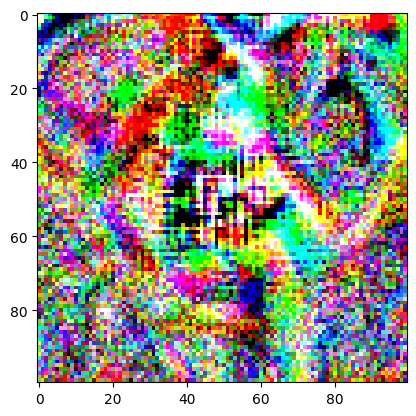

In [171]:
plt.imshow(np.squeeze(out.data.detach().numpy()).T)

In [59]:
out

tensor([[[[-6.4911e-02, -4.8490e-02, -8.9770e-02,  ..., -3.1502e-02,
           -3.1865e-02, -2.5294e-02],
          [ 5.2988e-02,  7.7667e-02,  1.5788e-01,  ..., -1.4425e-02,
           -1.3054e-02,  6.3388e-03],
          [ 1.5779e-01,  2.1875e-01,  1.4605e-01,  ...,  2.5471e-02,
            1.1511e-02,  1.2840e-02],
          ...,
          [-4.1452e-03, -4.7604e-02, -2.5352e-02,  ..., -1.9456e-03,
           -4.8128e-04, -2.6010e-03],
          [ 2.2462e-02, -9.0823e-03, -4.9111e-02,  ...,  6.0867e-03,
            8.1317e-04, -4.0758e-03],
          [-9.0705e-03,  1.1120e-02, -4.4653e-02,  ...,  7.4394e-03,
           -2.9990e-04,  2.3944e-04]],

         [[-8.8196e-02, -1.5338e-01, -1.1399e-01,  ..., -5.9189e-02,
           -7.1107e-02, -5.0001e-02],
          [-1.1981e-01, -3.4948e-01, -1.7581e-02,  ..., -4.3726e-02,
           -6.0823e-02, -1.8943e-02],
          [ 1.1945e-02, -2.8138e-01, -1.4650e-01,  ...,  4.1244e-02,
            2.1156e-02,  2.5894e-02],
          ...,
     

In [41]:
pyramid_image_org = PyramidImage(image)
org = pyramid_image_org.img_numpy

In [30]:
out.data.detach().numpy() == pyramid_image.data

False

In [39]:
processed = pyramid_image.img_numpy

In [40]:
processed.shape

(800, 1200, 3)

In [42]:
org.shape

(800, 1200, 3)

In [52]:
np.array_equal(org, processed)

True

In [46]:
out.shape

torch.Size([1, 3, 800, 1200])

In [51]:
processed = out.data.detach().numpy()
processed = np.squeeze(out.detach().numpy())
processed = processed.transpose(1, 2, 0)